## Лабораторная работа № 5
### Разделимость данных

Примените алгоритмы уменьшения размерности к данным из предыдущей лабораторной, объясните полученные результаты

1. С помощью любого из рассмотренных на лекциях алгоритмов снижения размерности спроецируйте тренировочные данные в 2d пространство. Визуализируйте результаты снижения размерности. Цветом обозначьте категорию объекта
2. Примените алгоритм кластеризации к спроецированным данным. Расчитайте средние внутрикластерное и межкласторное расстояния получившейся проекции
3. Опишите результаты

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn; seaborn.set()  # for plot styling
from sklearn.metrics import pairwise_distances_argmin
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA


In [2]:
df = pd.read_csv("SpotifyFeatures.csv")
df = df.sample(10000, random_state=1234)
df.head()

,genre,artist_name,track_name,track_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
210275,World,Manu Chao,Malegría,7CU9coD7J9xunQCvKEHrOf,48,0.1530,0.685,175280,0.888,0.016300,A,0.364,-8.396,Minor,0.0891,121.972,4/4,0.5980
140897,Indie,Mansionair,Heirloom,0o0dUA3rGDraZpumU6ZJT8,38,0.2120,0.444,272240,0.848,0.096200,A,0.149,-8.512,Minor,0.0764,180.029,4/4,0.4380
54614,Movie,Chorus,Baan Thilidiththu,1CnfPeVl2AoW0MNvWh9XXm,0,0.5590,0.704,287007,0.711,0.000034,B,0.123,-7.311,Minor,0.0590,171.977,4/4,0.5450
183566,Movie,Lillias White,"Ooh, What You Said!",5jsNyuEPzveshOWo03lmIE,21,0.5210,0.646,292640,0.209,0.000000,A#,0.224,-15.663,Minor,0.2850,110.371,4/4,0.3470
100649,Children’s Music,Escape the Fate,The Guillotine,1AoZIZSOgkRlZrKXq2QduS,51,0.0127,0.442,272493,0.947,0.000003,E,0.406,-4.817,Minor,0.1810,100.044,4/4,0.0925


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 210275 to 218333
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   genre             10000 non-null  object 
 1   artist_name       10000 non-null  object 
 2   track_name        10000 non-null  object 
 3   track_id          10000 non-null  object 
 4   popularity        10000 non-null  int64  
 5   acousticness      10000 non-null  float64
 6   danceability      10000 non-null  float64
 7   duration_ms       10000 non-null  int64  
 8   energy            10000 non-null  float64
 9   instrumentalness  10000 non-null  float64
 10  key               10000 non-null  object 
 11  liveness          10000 non-null  float64
 12  loudness          10000 non-null  float64
 13  mode              10000 non-null  object 
 14  speechiness       10000 non-null  float64
 15  tempo             10000 non-null  float64
 16  time_signature    10000 non-null  

Начнем с задачи уменьшения размерности пространства признаков. Для этого удалим точно не нужные признаки, такие как название песни, ее id. Так же приведем все признаки к категориальным.

In [4]:
df.drop(['track_name', 'track_id', 'artist_name'], axis = 1, inplace = True)
df.tail()

,genre,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
180206,Jazz,43,0.532000,0.4060,480533,0.8500,0.000234,A,0.8760,-6.428,Minor,0.0671,102.198,4/4,0.5100
155179,Rock,50,0.000028,0.3730,302560,0.8950,0.020500,A#,0.3380,-5.217,Minor,0.1110,99.849,4/4,0.1850
123372,Classical,40,0.977000,0.2160,323440,0.0174,0.919000,D#,0.0843,-30.924,Major,0.0448,67.318,4/4,0.0375
96275,Indie,55,0.426000,0.8210,237520,0.5420,0.001500,F#,0.1760,-6.842,Major,0.0902,99.010,4/4,0.7390
218333,World,39,0.884000,0.0655,491333,0.0455,0.369000,D,0.1040,-26.592,Minor,0.0494,66.915,4/4,0.0388


In [5]:
genre_codes, unique_genre = pd.factorize(df.genre)
df.genre = genre_codes

key_codes, unique_keys = pd.factorize(df.key)
df.key = key_codes

df["mode"] = df["mode"].apply(lambda x: 1 if x == "Major" else 0)

time_codes, unique_sign = pd.factorize(df.time_signature)
df.time_signature = time_codes

def modify_func(x: float) -> int:
    if x <= 0.48:
        return 0
    if x <= 0.65:
        return 1
    return 2


y = df.danceability.apply(modify_func)
df.drop(["danceability"], axis=1, inplace=True)

df.head()

,genre,popularity,acousticness,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
210275,0,48,0.1530,175280,0.888,0.016300,0,0.364,-8.396,0,0.0891,121.972,0,0.5980
140897,1,38,0.2120,272240,0.848,0.096200,0,0.149,-8.512,0,0.0764,180.029,0,0.4380
54614,2,0,0.5590,287007,0.711,0.000034,1,0.123,-7.311,0,0.0590,171.977,0,0.5450
183566,2,21,0.5210,292640,0.209,0.000000,2,0.224,-15.663,0,0.2850,110.371,0,0.3470
100649,3,51,0.0127,272493,0.947,0.000003,3,0.406,-4.817,0,0.1810,100.044,0,0.0925


Применим алгоритмы снижения размерности TSNE и PCA к нашим данным.

Meaning of the 2 components:
0.000 x 2 + -0.000 x 0 + 0.000 x 2 + 1.000 x 1 + -0.000 x 0 + 0.000 x 0 + -0.000 x 0 + 0.000 x 0 + -0.000 x 1 + -0.000 x 2 + -0.000 x 2 + -0.000 x 0 + -0.000 x 1 + -0.000 x 2
-0.004 x 2 + 0.078 x 0 + -0.003 x 2 + 0.000 x 1 + 0.002 x 0 + -0.001 x 0 + -0.001 x 0 + -0.000 x 0 + 0.050 x 1 + -0.000 x 2 + -0.000 x 2 + 0.996 x 0 + -0.001 x 1 + 0.001 x 2


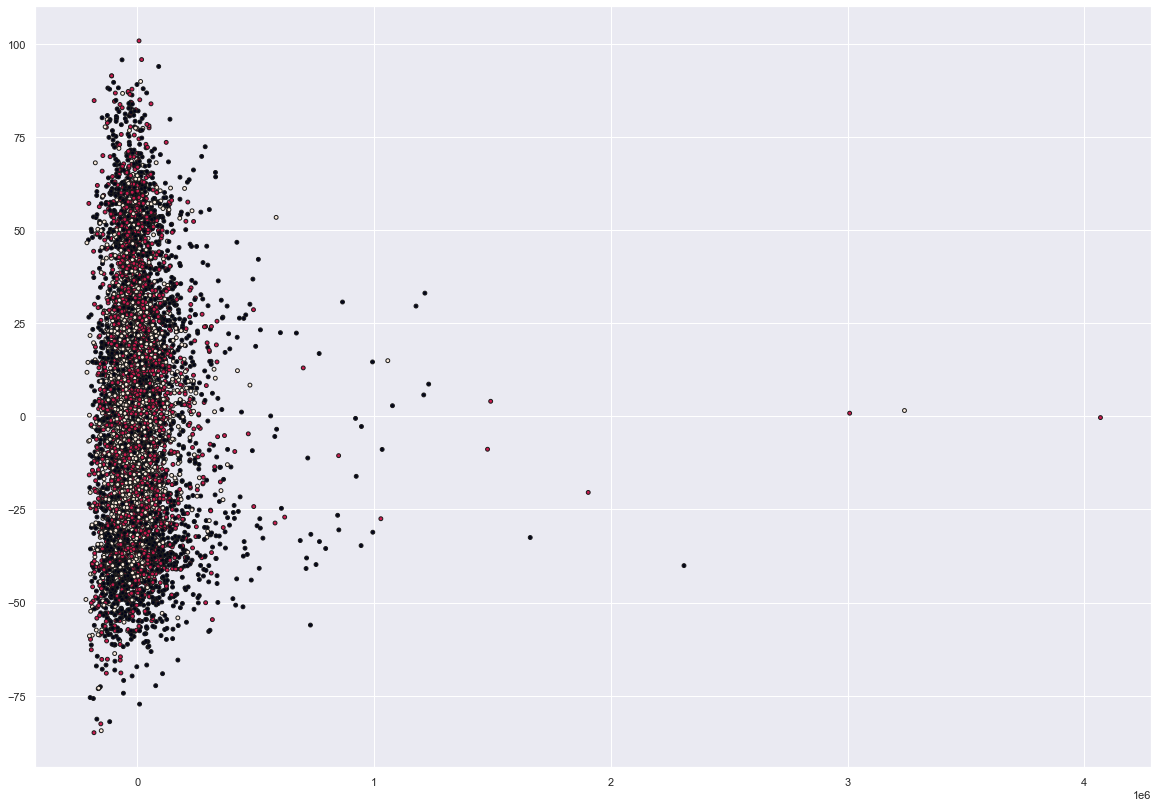

In [6]:
pca = PCA(n_components=2)
df_reduced_pca = pca.fit_transform(df)

print("Meaning of the 2 components:")
for component in pca.components_:
    print(" + ".join("%.3f x %s" % (value, name)
                     for value, name in zip(component,
                                            y)))
plt.figure(figsize=(20,14))
plt.scatter(df_reduced_pca[:, 0], df_reduced_pca[:, 1], c=y, s=15, edgecolor="k")
plt.show()

c:\users\sanev\appdata\local\programs\python\python39\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\users\sanev\appdata\local\programs\python\python39\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


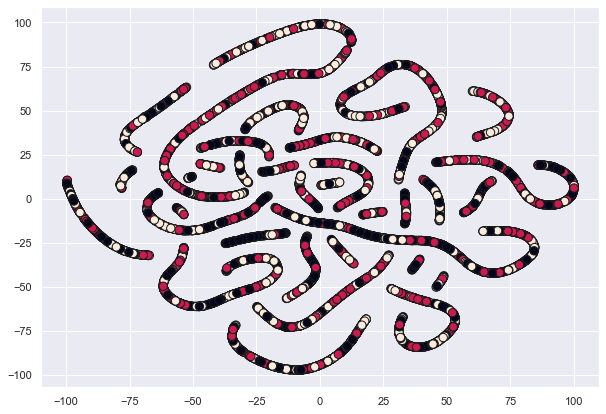

In [7]:
tsne = TSNE(random_state=112)
df_reduced_tsne = tsne.fit_transform(df)
plt.figure(figsize=(10,7))
plt.scatter(df_reduced_tsne[:, 0], df_reduced_tsne[:, 1], c=y, s=70, edgecolor="k")
plt.show()

Теперь перейдем к кластеризации с помощью алгоритма k-средних.

In [8]:
from sklearn.cluster import KMeans

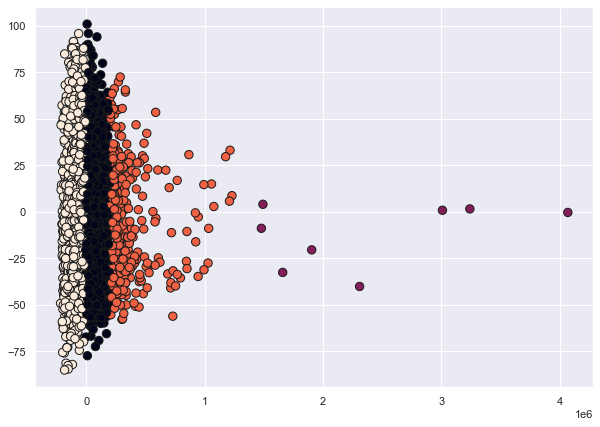

In [9]:
pred_pca = KMeans(n_clusters=4, random_state=1231).fit_predict(df_reduced_pca)
plt.figure(figsize=(10,7))
plt.scatter(df_reduced_pca[:, 0], df_reduced_pca[:, 1], c=pred_pca, s=70, edgecolor="k")
plt.show()

In [10]:
print(df_reduced_pca)
print(pred_pca)

[[-5.99167908e+04  4.45134706e+00]
 [ 3.70432086e+04  6.24717491e+01]
 [ 5.18102087e+04  5.16908798e+01]
 ...
 [ 8.82432099e+04 -5.02846941e+01]
 [ 2.32320945e+03 -1.71480916e+01]
 [ 2.56136210e+05 -4.87074408e+01]]
[3 0 0 ... 0 0 2]


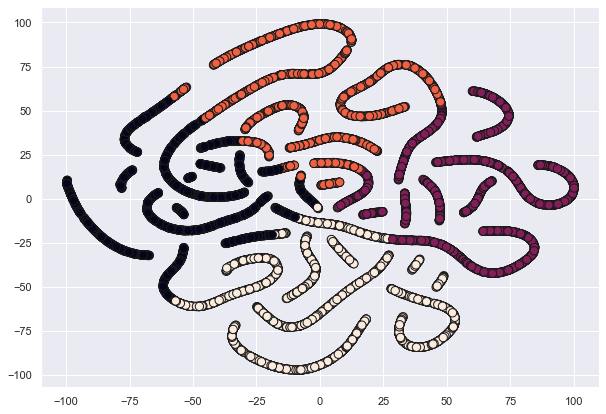

In [11]:
pred_tsne = KMeans(n_clusters=4, random_state=1231).fit_predict(df_reduced_tsne)
plt.figure(figsize=(10,7))
plt.scatter(df_reduced_tsne[:, 0], df_reduced_tsne[:, 1], c=pred_tsne, s=70, edgecolor="k")
plt.show()

In [12]:
from scipy.spatial import distance
def F0(x_reduced, y_kmeans): 
    sum = 0
    cnt = 0
    ans = 0
    for i in range (len(y_kmeans)):
        for j in range (i):
            if (y_kmeans[i] == y_kmeans[j]):
                sum+=distance.euclidean(x_reduced[i],x_reduced[j])
                cnt+=1
    return sum / cnt

def F1(x_reduced,  y_kmeans): 
    sum = 0
    cnt = 0
    ans = 0
    for i in range (len(y_kmeans)):
        for j in range (i):
            if (y_kmeans[i] != y_kmeans[j]):
                sum+=distance.euclidean(x_reduced[i],x_reduced[j])
                cnt+=1
    return sum / cnt




In [13]:
x1 = F0(df_reduced_tsne, pred_tsne)
y1 = F1(df_reduced_tsne, pred_tsne)
x2 = F0(df_reduced_pca, pred_pca)
y2 = F1(df_reduced_pca, pred_pca)
print(x1)
print(y1)
print(x2)
print(y2)
print(x1 / y1)
print(x2 / y2)

43.91687602309268
96.34022056926017
47746.67143082306
146311.5643612156
0.4558519356048214
0.32633559513413135
